## Import Data and Necessaries

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import os

import random
import shutil
from pathlib import Path

In [ ]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-2019-data -p /content/

Dataset URL: https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data
License(s): CC0-1.0
 92% 219M/238M [00:02<00:00, 82.6MB/s]
100% 238M/238M [00:02<00:00, 87.6MB/s]


In [ ]:
!unzip diabetic-retinopathy-224x224-2019-data.zip -d /content/  # Extract to a folder

Archive:  diabetic-retinopathy-224x224-2019-data.zip
  inflating: /content/colored_images/Mild/0024cdab0c1e.png  
  inflating: /content/colored_images/Mild/00cb6555d108.png  
  inflating: /content/colored_images/Mild/0124dffecf29.png  
  inflating: /content/colored_images/Mild/01b3aed3ed4c.png  
  inflating: /content/colored_images/Mild/0369f3efe69b.png  
  inflating: /content/colored_images/Mild/03e25101e8e8.png  
  inflating: /content/colored_images/Mild/04ac765f91a1.png  
  inflating: /content/colored_images/Mild/059bc89df7f4.png  
  inflating: /content/colored_images/Mild/05a5183c92d0.png  
  inflating: /content/colored_images/Mild/0684311afdfc.png  
  inflating: /content/colored_images/Mild/06b71823f9cd.png  
  inflating: /content/colored_images/Mild/07929d32b5b3.png  
  inflating: /content/colored_images/Mild/07a1c7073982.png  
  inflating: /content/colored_images/Mild/086d41d17da8.png  
  inflating: /content/colored_images/Mild/09935d72892b.png  
  inflating: /content/colored_im

In [ ]:
os.makedirs('/root/.cache/torch/checkpoints')

In [ ]:
!cp ../input/resnet34fastai/resnet34.pth /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth

cp: cannot stat '../input/resnet34fastai/resnet34.pth': No such file or directory


In [ ]:
model_path = 'models'
plot_path = 'plots'

if not os.path.exists(model_path):
    os.makedirs(model_path)
    os.makedirs(os.path.join(model_path, plot_path))

In [ ]:
'''
Severity Levels

0 - 'No_DR',
1 - 'Mild',
2 - 'Moderate',
3 - 'Severe',
4 - 'Proliferate_DR'
'''

classes = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']

In [ ]:
source_dir = Path('/content/colored_images')
test_dir = Path('/content/test_images')
train_dir = Path('/content/train_images')

# Make Directory
train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

def create_class_folders(base_path, classes):
    for cls in classes:
        (base_path / cls).mkdir(parents=True, exist_ok=True)

classes = [cls.name for cls in source_dir.iterdir() if cls.is_dir()]

create_class_folders(train_dir, classes)
create_class_folders(test_dir, classes)

for cls in classes:
    class_folder = source_dir / cls
    images = [f for f in class_folder.iterdir() if f.is_file()]

    random.shuffle(images)
    train_split = int(0.8 * len(images))

    # Image for Train
    train_images = images[:train_split]
    for img in train_images:
        target_path = train_dir / cls / img.name
        if not target_path.exists():
            shutil.copy(img, target_path)

    # Image for Test
    test_images = images[train_split:]
    for img in test_images:
        target_path = test_dir / cls / img.name
        if not target_path.exists():
            shutil.copy(img, target_path)

print("Data splitted to train (75%) and test (25%)")

Data splitted to train (75%) and test (25%)


# Default Model (ResNet34)

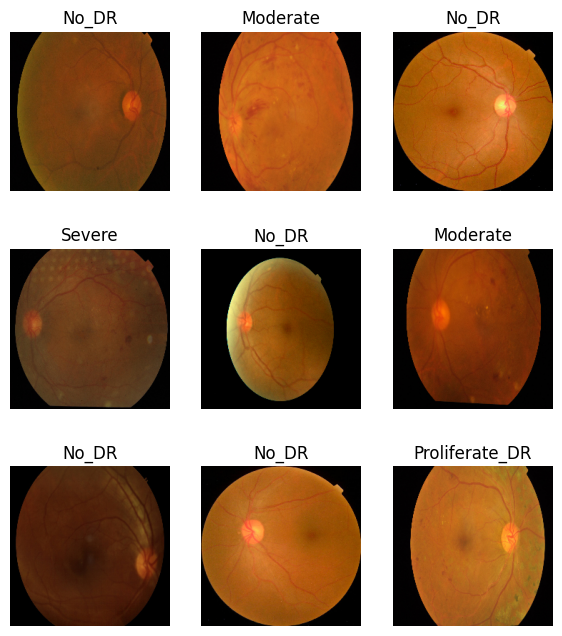

In [ ]:
tr_path = Path('/content/train_images')

dls = ImageDataLoaders.from_folder(
    path = tr_path,
    train = train_images,
    item_tfms=Resize(224),  # Resize to 224x224
    valid_pct=0.15,          # 20% for validate
    seed=42,
    bs=32,
    num_workers=4
)

dls.show_batch(max_n=9, figsize=(7, 8))

In [ ]:
dls.c, len(dls.train_ds), len(dls.valid_ds)

(5, 2490, 439)

In [ ]:
learn = vision_learner(
    dls,
    models.resnet34,
    pretrained=True, # Use pre-trained model (default True)
    metrics=[accuracy, error_rate]
)

# Fine-tune model 8 epochs
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 168MB/s]


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.372162,0.751347,0.783599,0.216401,00:14


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.785745,0.642086,0.806378,0.193622,00:16
1,0.655478,0.617552,0.794989,0.205011,00:16
2,0.453755,0.588959,0.813212,0.186788,00:16
3,0.230591,0.597624,0.826879,0.173121,00:16
4,0.107696,0.583507,0.829157,0.170843,00:16


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=1.4454397387453355e-05)

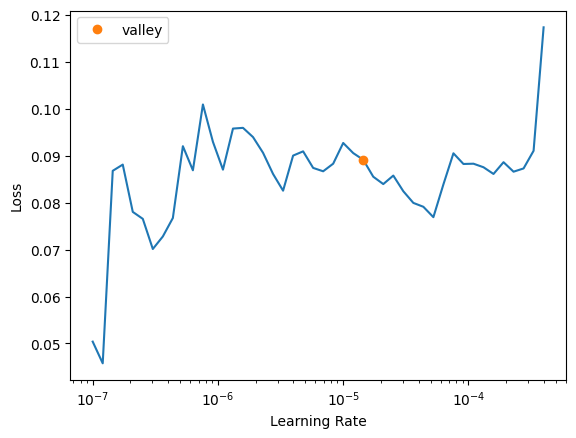

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(
    20, # Epoch
    lr_max = slice(1e-5,1e-4),
    cbs=[EarlyStoppingCallback(monitor='accuracy', patience=5)])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.095668,0.594252,0.822323,0.177677,00:16
1,0.062717,0.611646,0.826879,0.173121,00:16
2,0.089327,0.647722,0.829157,0.170843,00:16
3,0.103837,0.736140,0.815490,0.184510,00:15
4,0.094836,0.692863,0.824601,0.175399,00:17
5,0.086396,0.750130,0.826879,0.173121,00:16
6,0.072506,0.702696,0.820046,0.179954,00:16
7,0.075943,0.644036,0.842825,0.157175,00:16
8,0.064376,0.793483,0.822323,0.177677,00:16
9,0.049642,0.747945,0.831435,0.168565,00:16


No improvement since epoch 12: early stopping


In [ ]:
# Save the trained model
learn.export(fname='/content/models/ori_model.pkl')

Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


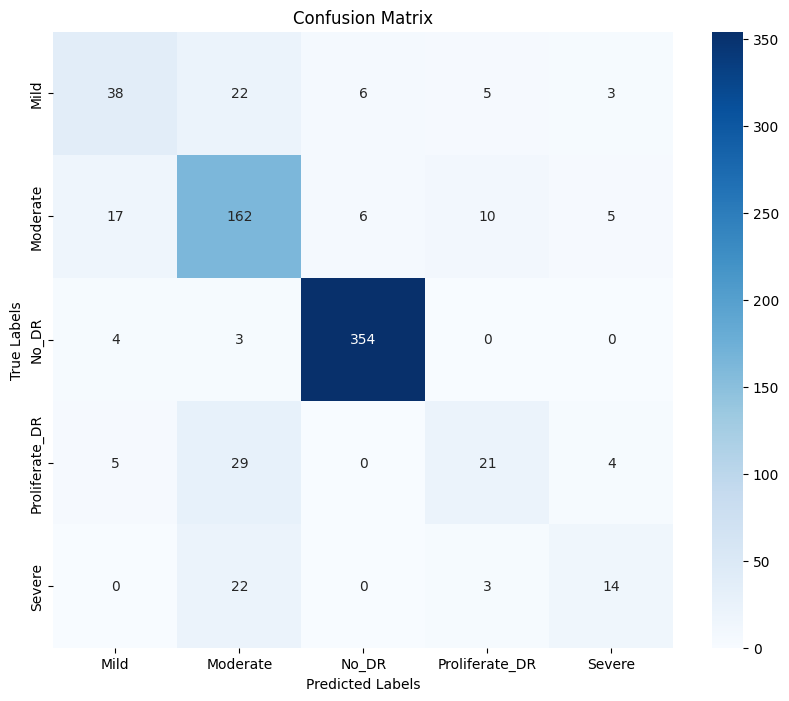

In [ ]:
test_images = get_image_files('/content/test_images')

vocab = learn.dls.vocab

def get_true_labels(files):
    return [f.parent.name for f in files]

true_labels = get_true_labels(test_images)
true_labels_int = np.array([vocab.o2i[label] for label in true_labels])

predicted_labels = []

for file in test_images:
    img = PILImage.create(file)
    pred, _, _ = learn.predict(img)
    print(f"Predicted: {pred}, Type: {type(pred)}")  # Print to check the type
    predicted_labels.append(vocab.o2i.get(pred, -1))  # Use .get to avoid KeyError

predicted_labels = np.array(predicted_labels)

confusion_mat = confusion_matrix(true_labels_int, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=vocab, yticklabels=vocab)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
accuracy = accuracy_score(true_labels_int, predicted_labels)
f1 = f1_score(true_labels_int, predicted_labels, average='macro')
precision = precision_score(true_labels_int, predicted_labels, average='macro')
recall = recall_score(true_labels_int, predicted_labels, average='macro')
report = classification_report(true_labels_int, predicted_labels, target_names=vocab)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("\nClassification Report:\n", report)

Accuracy: 0.8035470668485676
F1 Score: 0.6247313047737745
Precision: 0.6637116921169476
Recall: 0.6038058988320503

Classification Report:
                 precision    recall  f1-score   support

          Mild       0.59      0.51      0.55        74
      Moderate       0.68      0.81      0.74       200
         No_DR       0.97      0.98      0.97       361
Proliferate_DR       0.54      0.36      0.43        59
        Severe       0.54      0.36      0.43        39

      accuracy                           0.80       733
     macro avg       0.66      0.60      0.62       733
  weighted avg       0.79      0.80      0.79       733



# Fine Tune Model (ResNet34)

In [ ]:
# from fastai.vision.all import *

# # Define data augmentation and preprocessing steps
# def get_data(bs, size):
#     return ImageDataLoaders.from_folder(
#         path,
#         train='.',  # Folder containing training images
#         valid_pct=0.3,  # 30% of data for validation
#         seed=42,  # Set seed for reproducibility
#         item_tfms=Resize(512),  # Resize all images to 224x224
#         batch_tfms=aug_transforms(  # Using built-in augmentation functions
#             do_flip=True,           # Horizontal flip (default)
#             max_rotate=20,          # Maximum rotation in degrees
#             max_lighting=0.5,       # Lighting adjustment range
#             p_lighting=0.9,        # Probability of lighting adjustments
#             xtra_tfms=[],           # List of additional custom transforms (if any)
#             size=size,              # Image size (224x224)
#         ),
#         bs=bs,  # Batch size
#         num_workers=4,  # Number of CPU workers for data loading
#         shuffle=True     # Shuffle the data for better training
#     )

# # Create data loaders
# data = get_data(bs=64, size=224)

# # Show a batch of augmented images and their corresponding labels
# data.show_batch(max_n=9, figsize=(7, 8))

# # Create a learner with ResNet34
# learn1 = vision_learner(
#     data,
#     models.resnet34,
#     pretrained=True,  # Use a pre-trained model (default True)
#     metrics=[accuracy, error_rate],  # Metrics to track during training
#     model_dir='/finetune_models',  # Directory where the model will be saved
#     path='/content'  # Path for the model and results
# )


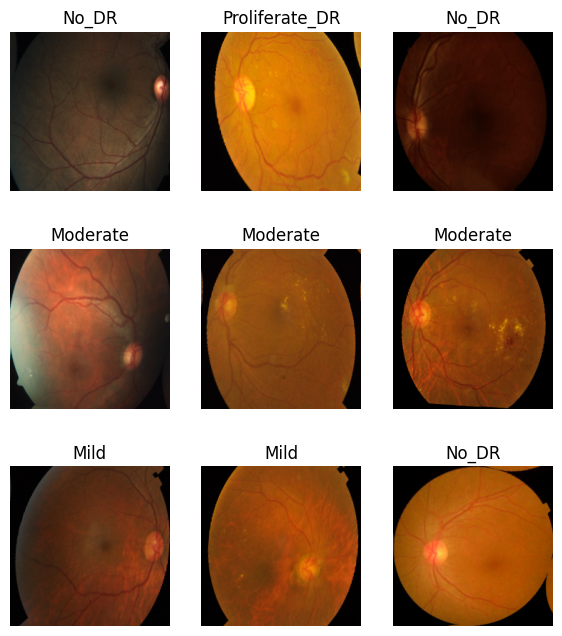

In [ ]:
from fastai.vision.all import *

# Define data augmentation and preprocessing steps
def get_data(bs, size):
    return ImageDataLoaders.from_folder(
        path = tr_path,
        train = train_images,  # Folder containing training images
        valid_pct=0.15,  # 20% of data for validation
        seed=42,  # Set seed for reproducibility
        item_tfms=Resize(224),  # Resize all images to 224x224
        batch_tfms=aug_transforms(  # Using built-in augmentation functions
            do_flip=True,           # Horizontal flip (default)
            max_rotate=12,          # Maximum rotation in degrees
            max_lighting=0.18,       # Lighting adjustment range
            p_lighting=0.9,        # Probability of lighting adjustments
            size=size,              # Image size (224x224)
        ),
        bs=bs,  # Batch size
        num_workers=4,  # Number of CPU workers for data loading
        shuffle=True     # Shuffle the data for better training
    )

# Create data loaders
data = get_data(bs=32, size=224)

# Show a batch of augmented images and their corresponding labels
data.show_batch(max_n=9, figsize=(7, 8))

In [ ]:
learn1 = vision_learner(
    data,
    models.resnet34,
    pretrained=True,  # Use a pre-trained model (default True)
    metrics=[accuracy, error_rate],  # Metrics to track during training
    path='/content/models/finetune1'  # Path for the model and results
)

learn1.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.439365,0.841105,0.749431,0.250569,00:20


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.978340,0.670825,0.774487,0.225513,00:22
1,0.788038,0.633158,0.774487,0.225513,00:22
2,0.753729,0.528197,0.833713,0.166287,00:20
3,0.641661,0.486228,0.824601,0.175399,00:18
4,0.569318,0.545568,0.813212,0.186788,00:18
5,0.480895,0.488542,0.822323,0.177677,00:18
6,0.428991,0.508884,0.815490,0.184510,00:18
7,0.343571,0.554232,0.799544,0.200456,00:18
8,0.308556,0.498671,0.813212,0.186788,00:18
9,0.288801,0.516224,0.824601,0.175399,00:18


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

SuggestedLRs(valley=1.2022644114040304e-05)

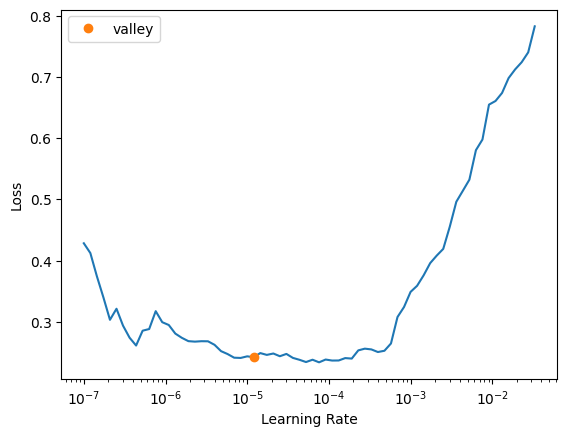

In [ ]:
learn1.unfreeze()
learn1.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.283260,0.584327,0.815490,0.184510,00:19
1,0.325788,0.696932,0.776765,0.223235,00:18
2,0.482340,0.474003,0.799544,0.200456,00:18
3,0.544253,0.499030,0.817768,0.182232,00:18
4,0.536546,0.579622,0.767654,0.232346,00:19
5,0.467735,0.570987,0.820046,0.179954,00:24
6,0.478839,0.510076,0.799544,0.200456,00:23
7,0.417241,0.453259,0.822323,0.177677,00:18
8,0.403607,0.546371,0.806378,0.193622,00:19
9,0.387838,0.569631,0.804100,0.195900,00:18


No improvement since epoch 12: early stopping


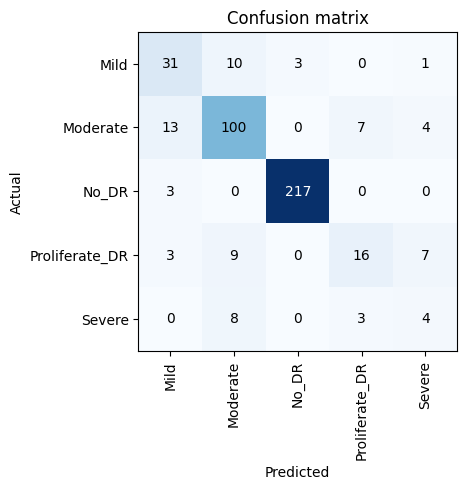

In [ ]:
from fastai.callback.tracker import EarlyStoppingCallback

learn1.fit_one_cycle(
    20,
    lr_max=slice(1e-4, 1e-3),
    cbs=[EarlyStoppingCallback(monitor='accuracy', patience=5)])

# Optional: Analyze the model performance with a confusion matrix
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix()

Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Mild, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: No_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Proliferate_DR, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Moderate, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


Predicted: Severe, Type: <class 'fastai.data.transforms.Category'>


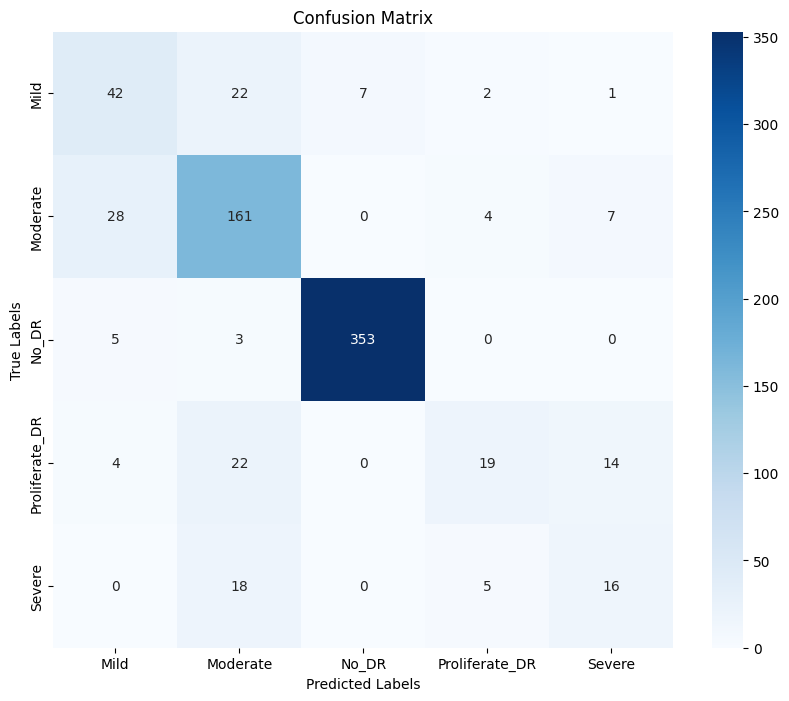

In [ ]:
test_images = get_image_files('/content/test_images')

vocab = learn1.dls.vocab

def get_true_labels(files):
    return [f.parent.name for f in files]

true_labels = get_true_labels(test_images)
true_labels_int = np.array([vocab.o2i[label] for label in true_labels])

predicted_labels = []

for file in test_images:
    img = PILImage.create(file)
    pred, _, _ = learn1.predict(img)
    print(f"Predicted: {pred}, Type: {type(pred)}")
    predicted_labels.append(vocab.o2i.get(pred, -1))

predicted_labels = np.array(predicted_labels)

confusion_mat = confusion_matrix(true_labels_int, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=vocab, yticklabels=vocab)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

accuracy = accuracy_score(true_labels_int, predicted_labels)
f1 = f1_score(true_labels_int, predicted_labels, average='macro')
precision = precision_score(true_labels_int, predicted_labels, average='macro')
recall = recall_score(true_labels_int, predicted_labels, average='macro')
report = classification_report(true_labels_int, predicted_labels, target_names=vocab)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("\nClassification Report:\n", report)

Accuracy: 0.8062755798090041
F1 Score: 0.6253268843766315
Precision: 0.6557952941238125
Recall: 0.6165394422618236

Classification Report:
                 precision    recall  f1-score   support

          Mild       0.53      0.57      0.55        74
      Moderate       0.71      0.81      0.76       200
         No_DR       0.98      0.98      0.98       361
Proliferate_DR       0.63      0.32      0.43        59
        Severe       0.42      0.41      0.42        39

      accuracy                           0.81       733
     macro avg       0.66      0.62      0.63       733
  weighted avg       0.80      0.81      0.80       733



In [ ]:
learn1.export('/content/models/resnet34_fine_tune.pkl')
print("Success")

Success


Prediction: Severe
Probability: tensor([5.1548e-06, 2.1862e-04, 2.2819e-10, 1.9363e-02, 9.8041e-01])


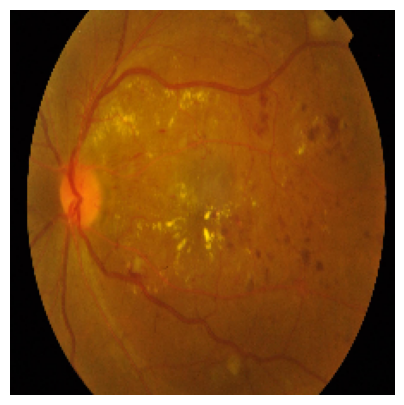

In [ ]:
learn = load_learner('/content/ori_model.pkl')
# Example usage with a single image file
test_image_path = '/content/test_images/Severe/91cf56d3d1af.png' # Replace with the actual path to your test image
img = PILImage.create(test_image_path)
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}")
print(f"Probability: {probs}")

# Display the image
img.show()
plt.show()